# Exercise: Principal Component Analysis

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise involves calculating sample-based covariance matrices of spectra, the eigenvalues and eigenvectors of these matrices, and the resulting principal component bases.   First import the dependencies.

In [1]:
import numpy as np
import pylab as plt
from scipy.linalg import norm, eig
import os.path
import figure_style

# Load Wavelengths
wavelengths = np.loadtxt(os.path.join('data','wavelengths.txt'))

# Load the data and convert to Band-In-Pixel interleave
filename = os.path.join('..','01_Introduction','data','ang20171108t184227_corr_v2p13_subset_bil')
rows, bands, cols = 500,425,680
mm = np.memmap(filename, dtype=np.float32, mode='r',shape=(rows, bands, cols))

Band-In-Pixel indexing order lets us easily reference the cube as a big continuous list of spectra in memory, and reshape into a 2-D matrix.  We can then write subsequent calculations as concise matrix operations.

In [2]:
X =  np.asarray(mm, dtype = np.float32).copy().transpose((0,2,1))
Xl = X.reshape((rows*cols, bands))

As before, we zero out deep water features and regions with suspect calibration.

In [3]:
# zero the deep water features and bad calibration in the extreme SWIR
opaque = np.logical_or(np.logical_and(wavelengths>1280, wavelengths<1450),
                        np.logical_and(wavelengths>1750, wavelengths<2000))
badcalibration = wavelengths>2480
bad = np.logical_or(opaque, badcalibration)
Xl[:,bad] = 0

Watch out for values of -9999 in the data, which indicate the periphery of the rectangular geographically-registered image where the pushbroom sensor did not actually acquire data.  We ignore these locations.

In [4]:
use = np.all(Xl>-9900,axis=1)
Xsub = Xl[use,:]

We don't require ALL the spectra to form our sample covariance matrix.  Here for speed I'll use every 40th spectrum in the list.  I calculate the sample mean and covariance using scipy's built-in functions, and plot the resulting covariance structure.  

<b> Question 1 </b> What do the block-diagonal structures in the covariance represent, both mathematically and physically?

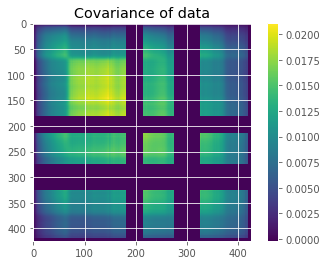

In [5]:
Xsub = Xsub[np.arange(0,Xsub.shape[0],40),:]
mu = Xsub.mean(axis=0)
Cov = np.cov(Xsub, rowvar=False);

plt.imshow(Cov)
plt.colorbar()
plt.title('Covariance of data')
plt.savefig(os.path.join('images','covariance.png'))

Next we calculate the eigenvalues and eigenvectors of the covariance, plot the top 10 principal components, and save the results to figures.

<b> Question 2 </b> Are any of the top PCs interpretable, and if so, what do they represent?

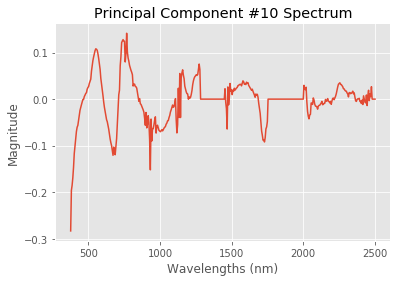

In [6]:
ev, evec = eig(Cov)

for i in range(10):
    plt.cla()
    plt.plot(wavelengths,evec[:,i])
    plt.xlabel('Wavelengths (nm)')
    plt.ylabel('Magnitude')
    plt.title('Principal Component #%i Spectrum'%(i+1))
    plt.savefig(os.path.join('images','evec%i_spectrum.png'%(i+1)));


# Bonus: Intrinsic dimensionality
__________

This bonus exercise involves calculating the intrinsic dimensionality of the Caltech scene.  We begin as in the prior exercise, importing the data, excluding bad pixels and spectral regions, calculating mean spectra and covaraince matrices, and finally eigenvectors.

In [7]:
import numpy as np
import pylab as plt
from scipy.linalg import norm, eig
import figure_style

# Load wavelengths, data, and convert to Band-In-Pixel interleave
wavelengths = np.loadtxt(os.path.join('data','wavelengths.txt'))
filename = os.path.join('..','01_Introduction','data','ang20171108t184227_corr_v2p13_subset_bil')
rows, bands, cols = 500,425,680
mm = np.memmap(filename, dtype=np.float32, mode='r',shape=(rows,bands,cols))
X = np.asarray(mm,dtype = np.float32).copy().transpose((0,2,1))

# Zero the deep water vapor features and bad calibration in the extreme SWIR
opaque = np.logical_or(np.logical_and(wavelengths>1280, wavelengths<1450),
                       np.logical_and(wavelengths>1750, wavelengths<2000))
badcalibration = wavelengths>2480
bad = np.logical_or(opaque, badcalibration)
X[:,:,bad] = 0

# Reshape as a list, exclude out-of-bounds areas, and subsample
Xl = X.reshape((rows*cols, bands))
use = np.all(Xl>-9900,axis=1)
Xsub = Xl[use,:]
Xsub = Xsub[np.arange(0,Xsub.shape[0],40),:]

# Calculate mean, covariance, and the covariance eigenvectors
mu = Xsub.mean(axis=0)
Cov = np.cov(Xsub, rowvar=False);
ev, evec = eig(Cov)

Plot the eigenvalue decay curve for the top 100 eigenvalues on a log vertical scale.  Is there an obvious "knee" or breakpoint we can use to determine the dimensionality?

/Users/drt/src/anaconda37/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


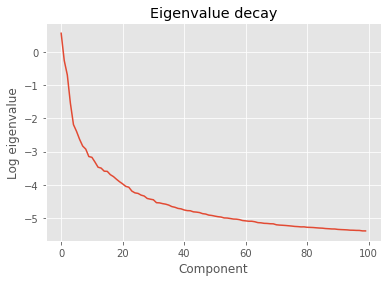

In [8]:
plt.plot(np.arange(100), np.log10(ev[:100]))
plt.title('Eigenvalue decay')
plt.xlabel('Component')
plt.ylabel('Log eigenvalue')
plt.savefig(os.path.join('images','decay.png'));

Next, represent the PC projections as a map.  Recall that the PC bases are orthonormal, and that their dot product with a spectrum is the magnitude of these projections.  Form a new cube with as many bands as the original, but for which each band represents the magnitude of the projection of that spectrum onto the associated PC. For instance, band 1 will map the projection onto the first PC, band 2 the second, etc.  This is a long calculation, so you might want to start with every 10th eigenvalue!  You may also wish to save diagnostic images using functions like imshow() and savefig().  I increase the figure size for better resolution.

In [13]:
from IPython.core.pylabtools import figsize
figsize(15,15/1.618)

X_zeromean = Xl - mu
X_proj = np.zeros((rows, cols, bands))
for i in range(0,bands,10):
    print('eigenvalue %i'%i)
    X_fixed = np.matmul(X_zeromean, evec[:,i])
    X_fixed[np.logical_not(use)] = 0
    X_proj[:,:,i] = X_fixed.reshape((rows,cols)) 
    plt.figure()
    plt.imshow(np.squeeze(X_proj[:,:,i]))
    plt.title('Principal Component %i Map'%i)
    plt.savefig(os.path.join('results','evec%i_map.png'%i));
    plt.close()

eigenvalue 0
eigenvalue 10
eigenvalue 20
eigenvalue 30
eigenvalue 40
eigenvalue 50
eigenvalue 60
eigenvalue 70
eigenvalue 80
eigenvalue 90
eigenvalue 100
eigenvalue 110
eigenvalue 120
eigenvalue 130
eigenvalue 140
eigenvalue 150
eigenvalue 160
eigenvalue 170
eigenvalue 180
eigenvalue 190
eigenvalue 200
eigenvalue 210
eigenvalue 220
eigenvalue 230
eigenvalue 240
eigenvalue 250
eigenvalue 260
eigenvalue 270
eigenvalue 280
eigenvalue 290
eigenvalue 300
eigenvalue 310
eigenvalue 320
eigenvalue 330
eigenvalue 340
eigenvalue 350
eigenvalue 360
eigenvalue 370
eigenvalue 380
eigenvalue 390
eigenvalue 400
eigenvalue 410
eigenvalue 420


Now, save the result as a new data cube.  

In [14]:
filename = os.path.join('results','pcs')
rows_out, cols_out, bands_out = 500,680,425
mm = np.memmap(filename, dtype=np.float32, mode='w+',shape=(rows_out,cols_out,bands_out))
mm[:,:,:] = X_proj

header_file = os.path.join('results','pcs.hdr')
header_content = '''ENVI
description = {Principal Components}
samples = ''' + str(cols_out) + '''
lines   = ''' + str(rows_out) + '''
bands   = ''' + str(bands_out) + '''
header offset = 0
file type = ENVI Standard
data type = 4
interleave = bip
sensor type = Unknown
byte order = 0'''

with open(header_file,'w') as fout:
    fout.write(header_content)

Load it in the visualization tool, and evaluate the spatial structure of each projection.  Very low eigenvalues are related to instrument noise.

<b> Question 1</b> At what eigenvalues does the spatial structure start to dissolve?  

<b> Question 2</b> Is there any spatial structure in the is the noise - and why?

<b> Question 3</b> What can we say about the intrinsic dimensionality observable above the noise level?

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.